# scada数据分析

## 读取原始数据

In [14]:
import sys
import os
searchPath=os.path.abspath('..')  # '../..' 代表添加当前路径的上两级目录；这种方法是运行时修改，脚本运行后就会失效
sys.path.append(searchPath)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rcParams
# 调整增加输出窗口显示数据
np.set_printoptions(precision=4, threshold=8, edgeitems=4, linewidth=75, suppress=True, nanstr='nan', infstr='inf')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
print('ready')

ready


In [7]:
# load data
file = 'scadaData.csv'
dataScada = pd.read_csv(file, index_col=False)  # encoding='GB18030'识别汉字表头；index_col=False 使得pandas不用第一列做索引（行名）
dataScada

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [8]:
dataScada.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [9]:
a=0
b=len(dataScada)
# Scada数据
serScada = pd.DataFrame(dataScada['Date/Time'][a:b].values, columns=['time'])  # 定义字典，装入数据,时间索引
serScada['time'] = pd.to_datetime(serScada['time'], format='%d %m %Y %H:%M')  # 4位年用Y，2位年用y
serScada['wind speed(m/s)'] = dataScada['Wind Speed (m/s)'][a:b].values
serScada['wind direction'] = dataScada['Wind Direction (°)'][a:b].values
serScada['theoretical power(kW)'] = dataScada['Theoretical_Power_Curve (KWh)'][a:b].values
serScada['active power(kW)'] = dataScada['LV ActivePower (kW)'][a:b].values
# 根据时间索引time列内容，删除重复记录的条目
serScada = serScada.drop_duplicates(subset='time')
# 用时间序列值作为index代替原序号标签
serScada.index = serScada['time'].values
serScada = serScada.drop(['time'],axis=1)
# 生成准确无误的时间序列，作为“时间基准”
time = pd.date_range(start='2018-1-1',end='2018-12-31 23:50',freq='10min')  # periods=b
serTime = pd.DataFrame({'num': np.array(range(len(time)))+1}, index = time)
# 与“时间序列基准”合并；删除“时间基准”中序号（此序号伴随无效数据有丢失）
serScada = pd.merge(serTime, serScada, left_index=True, right_index=True, how='inner')
serScada = serScada.drop(['num'],axis=1)
serScada = pd.merge(serTime, serScada, left_index=True, right_index=True, how='outer')
# 检查时间序列是否按照正常顺序排列
print('检查序列顺序:')
for i in range(len(serScada)):
    if i+1==serScada['num'][i]:
        continue
    else:
        print(i)
# 显示有空值的条目
print('检查空值:')
print(serScada[serScada.isnull().T.any()])
serScada=serScada.fillna(method="bfill", axis=0)   # 填充df中的空值 bfill:用后面数值填充 fill:用前面填充  填充方法可以进行优化
print(serScada[serScada.isnull().T.any()])
serScada

检查序列顺序:
检查空值:
                       num  wind speed(m/s)  wind direction  theoretical power(kW)  active power(kW)
2018-01-04 09:50:00    492              NaN             NaN                    NaN               NaN
2018-01-04 10:00:00    493              NaN             NaN                    NaN               NaN
2018-01-04 10:10:00    494              NaN             NaN                    NaN               NaN
2018-01-04 10:20:00    495              NaN             NaN                    NaN               NaN
2018-01-04 10:30:00    496              NaN             NaN                    NaN               NaN
...                    ...              ...             ...                    ...               ...
2018-12-17 10:10:00  50462              NaN             NaN                    NaN               NaN
2018-12-17 10:20:00  50463              NaN             NaN                    NaN               NaN
2018-12-17 10:30:00  50464              NaN             NaN                  

,num,wind speed(m/s),wind direction,theoretical power(kW),active power(kW)
2018-01-01 00:00:00,1,5.311336,259.994904,416.328908,380.047791
2018-01-01 00:10:00,2,5.672167,268.641113,519.917511,453.769196
2018-01-01 00:20:00,3,5.216037,272.564789,390.900016,306.376587
2018-01-01 00:30:00,4,5.659674,271.258087,516.127569,419.645905
2018-01-01 00:40:00,5,5.577941,265.674286,491.702972,380.650696
...,...,...,...,...,...
2018-12-31 23:10:00,52556,11.404030,80.502724,3397.190793,2963.980957
2018-12-31 23:20:00,52557,7.332648,84.062599,1173.055771,1684.353027
2018-12-31 23:30:00,52558,8.435358,84.742500,1788.284755,2201.106934
2018-12-31 23:40:00,52559,9.421366,84.297913,2418.382503,2515.694092


## 风向强度极坐标分布图

In [26]:
ser = np.zeros([36,5])
for i in np.array(range(len(serScada))):  # len(serScada)
    a=int(serScada.iloc[i,2]//10)  # 计算方向36分位
    b=int(serScada.iloc[i,1]//5)  # 计算风速从属区间
    if b>=5:
        b=4
    ser[a,b]=ser[a,b]+1
ser

array([[1293.,  854.,  727.,    1.,    0.],
       [ 544.,  672.,  216.,   40.,    0.],
       [ 825., 1516.,  513.,   45.,    0.],
       [ 729., 2170.,  854.,  161.,    0.],
       ...,
       [ 302.,   51.,   12.,    0.,    0.],
       [ 313.,   72.,   24.,    0.,    0.],
       [ 331.,   77.,   38.,    0.,    0.],
       [ 372.,  145.,   49.,    1.,    0.]])

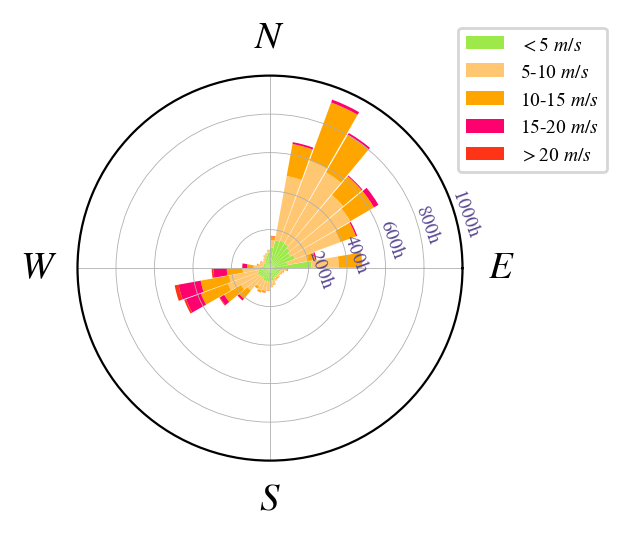

In [27]:
matplotlib.rcdefaults()  # 将配置重置为默认值
# 将配置重置为默认值
# plt.rcdefaults()
# config = {
#     "font.family": 'serif',
#     "font.size": 15,
#     "mathtext.fontset": 'stix',
#     "font.serif": ['SimSun']
# }
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)
# matplotlib.use("Agg")
# matplotlib.rcParams['text.usetex'] = True  # 全局开启
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['font.sans-serif'] = ['Times New Roman']
# Compute pie slices
colors=['#9EE94A','#FFC771','#FFA500','#FF006F','#FF3416']
N = 36  # 扇形数量
theta = np.linspace(0.0+2 * np.pi/36/2, 2 * np.pi+2 * np.pi/36/2, N, endpoint=False)  # 分位点在圆周的位置
radii1 = ser[:,0]  # <5
radii2 = ser[:,1]  # 5-10
radii3 = ser[:,2]  # 10-15
radii4 = ser[:,3]  # 15-20 
radii5 = ser[:,4]  # >20
width = np.pi / 19 * np.ones(N)  # 每个扇形宽度
plt.figure(figsize=(5.5, 2.5), dpi=200)
ax = plt.subplot(111, projection='polar')
bars1 = ax.bar(theta, radii1, width=width, color=colors[0], label='$<$5 $m/s$', bottom=0.0)
bars2 = ax.bar(theta, radii2, width=width, color=colors[1], label='5-10 $m/s$', bottom=radii1)
bars3 = ax.bar(theta, radii3, width=width, color=colors[2], label='10-15 $m/s$', bottom=radii1+radii2)
bars4 = ax.bar(theta, radii4, width=width, color=colors[3], label='15-20 $m/s$', bottom=radii1+radii2+radii3)
bars5 = ax.bar(theta, radii5, width=width, color=colors[4], label='$>$20 $m/s$', bottom=radii1+radii2+radii3+radii4)

theta_labels = np.linspace(0, 2*np.pi, 4, endpoint=False)
theta_labels = np.concatenate((theta_labels, [theta_labels[0]]))
# 将4个弧度转换成角度，并分别设置标签
labels = np.array(['$E$','$N$','$W$','$S$'])
plt.thetagrids(theta_labels[:4] * 180/np.pi, labels, fontsize=14)  # 圆周标签

# 设置刻度范围、标题、图例
plt.yticks([1200,2400,3600,4800,6000], ['200h','400h','600h','800h','1000h'], color="#5a4992")
plt.tick_params(axis='y', labelsize=7, rotation=-70, pad=2)  # 刻度值 ///////////////////注意使用tex字体尽量不要小于7,否则会有扁掉的感觉
plt.ylim(0, 6000)  # 刻度范围
# plt.title('Title 图一', fontsize=14)  # 标题
plt.grid(linewidth = 0.3)  # linestyle='--',
plt.legend(bbox_to_anchor=(1.4, 1.15), prop={"size": 7})  # 右上角图例  , frameon=False
plt.savefig('./output/radar_wsAndWD.png', dpi=600) # , bbox_inches = 'tight', pad_inches = .5设置外围页边距，设置画布大小后用不到

plt.show()

In [13]:
print(3.5*2.54, 2.5*2.54)

8.89 6.35


## 风速月份分布

In [4]:
serScada

,num,wind speed(m/s),wind direction,theoretical power(kW),active power(kW)
2018-01-01 00:00:00,1,5.311336,259.994904,416.328908,380.047791
2018-01-01 00:10:00,2,5.672167,268.641113,519.917511,453.769196
2018-01-01 00:20:00,3,5.216037,272.564789,390.900016,306.376587
2018-01-01 00:30:00,4,5.659674,271.258087,516.127569,419.645905
2018-01-01 00:40:00,5,5.577941,265.674286,491.702972,380.650696
...,...,...,...,...,...
2018-12-31 23:10:00,52556,11.404030,80.502724,3397.190793,2963.980957
2018-12-31 23:20:00,52557,7.332648,84.062599,1173.055771,1684.353027
2018-12-31 23:30:00,52558,8.435358,84.742500,1788.284755,2201.106934
2018-12-31 23:40:00,52559,9.421366,84.297913,2418.382503,2515.694092


In [17]:
# 按月份切割数据
ser = pd.DataFrame()
for i in np.array(range(12)):
    ser[str(i)]=serScada.iloc[i*6*24*29:(i+1)*6*24*29,1].values
ser

,0,1,2,3,4,5,6,7,8,9,10,11
0,5.311336,10.559700,18.450510,10.473630,2.523973,8.848398,7.588017,1.419352,10.43579,10.513770,5.897909,8.628481
1,5.672167,10.559700,18.356291,10.631830,2.809628,9.589136,8.510858,1.052042,10.20953,11.192630,5.988924,9.580752
2,5.216037,10.559700,18.894991,9.766035,3.688556,9.572860,8.682347,0.683935,10.24300,10.238090,6.075747,10.000970
3,5.659674,10.559700,18.982269,10.053500,3.893305,10.096450,9.521110,1.196238,10.96553,10.737990,5.647635,9.799096
4,5.577941,10.559700,19.382460,10.540880,3.077575,9.516030,8.595299,1.169498,10.68246,10.883140,6.186305,7.779602
...,...,...,...,...,...,...,...,...,...,...,...,...
4171,10.559700,16.987820,9.654511,2.426864,8.393629,8.864607,3.162038,10.848870,12.15341,6.512153,8.994679,12.068690
4172,10.559700,17.787411,9.795296,2.144141,7.955787,9.484924,3.063479,10.670630,12.61522,6.815685,8.805612,13.433530
4173,10.559700,17.660540,10.133360,2.600033,8.335361,9.149471,2.184332,11.149630,12.01689,6.450552,8.193623,13.456450
4174,10.559700,17.828991,9.616941,2.641853,8.548473,8.949309,0.878079,10.656090,11.52503,6.100579,7.302529,13.504950


<function matplotlib.pyplot.show(close=None, block=None)>

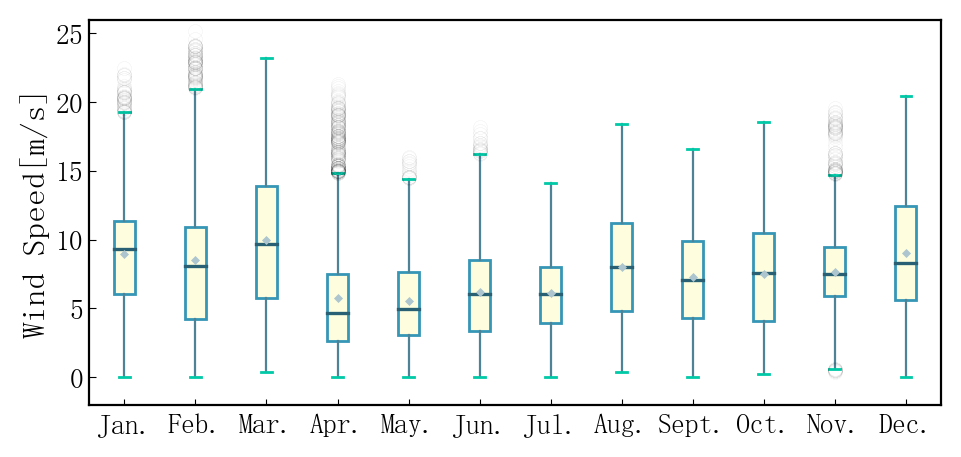

In [24]:
# 将配置重置为默认值
matplotlib.rcdefaults()
# 将配置重置为默认值
# plt.rcdefaults()
# config = {
#     "font.family": 'serif',
#     "font.size": 15,
#     "mathtext.fontset": 'stix',
#     "font.serif": ['SimSun']
# }
# plt.rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)
# matplotlib.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['text.usetex'] = True
# matplotlib.rcParams['mathtext.default'] = 'regular'
# plt.rcParams['font.family'] = 'Times New Roman'  # Helvetica Times New Roman
# plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

colors = ["#3596B5", "#FEFEDF", "#296073", "#ADC5CF", "#4E8397", "#00C9A7"]  # 0箱体边框、1箱体填充、2中位数线、3均值点、4须、5极值线、

# plt.figure(figsize=(3.5, 2.5),dpi=600) # 创建画板
fig, ax1 = plt.subplots(figsize=(5.5, 2.5), dpi=200)
plt.boxplot(ser,
            widths=0.3,  # 箱体边框宽度
            labels=['Jan.','Feb.','Mar.','Apr.','May.','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.'],
            patch_artist=True, boxprops={'color':colors[0], 'facecolor':colors[1], 'linewidth':1},  # 箱体边框颜色；箱体填充色；箱体框线粗细 lightblue
            medianprops=dict(color=colors[2], linewidth=1.2),  # 中位数线颜色、粗细
            showmeans=True, meanprops={'color':colors[3], 'markeredgecolor':colors[3], 'markerfacecolor':colors[3], 'marker':'D','markersize':1.3},  # 均值点标记
            whiskerprops=dict(color=colors[4], linewidth=.8),  # 须的颜色、粗细
            showcaps=True, capprops={'color':colors[5], 'linewidth':1},  # 极值线颜色、粗细
            showfliers=True, flierprops={'color':'b', 'linewidth':100, 'markeredgewidth':0.01, 'markersize':5})  # 异常值点设置, sym = '*', 'markeredgewidth':标记点轮廓线粗细, 'markersize':标记点大小

#设置主刻度标签的位置
# ax1.yaxis.set_major_locator(MultipleLocator(5)) #将y轴主刻度标签设置为 的倍数
# 设置次刻度标签的位置
# ax1.yaxis.set_minor_locator(MultipleLocator(1)) #将此y轴次刻度标签设置为 的倍数

plt.ylim((-2, 26))
# plt.title('Examples of boxplot', fontsize=20)  # 标题，并设定字号大小
plt.tick_params(axis='x', labelsize=10, direction='in', pad=3, length=2, width=0.4, rotation=0)  # 刻度值大小
plt.tick_params(axis='y', labelsize=10, direction='in', pad=2, length=2.4, width=0.4)
ax1.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3, color="green")
# plt.gcf().autofmt_xdate()  # 自动旋转日期标记
plt.ylabel('Wind Speed[m/s]', fontsize=12, labelpad=2)  # 设置 y 轴标签文字、大小
plt.xlabel('', fontsize=12)  # 设置 x 轴标签文字、大小
# plt.xticks(rotation=0)

plt.savefig("./output/WS_monuth.png", dpi=600)

plt.show

CN版

<function matplotlib.pyplot.show(close=None, block=None)>

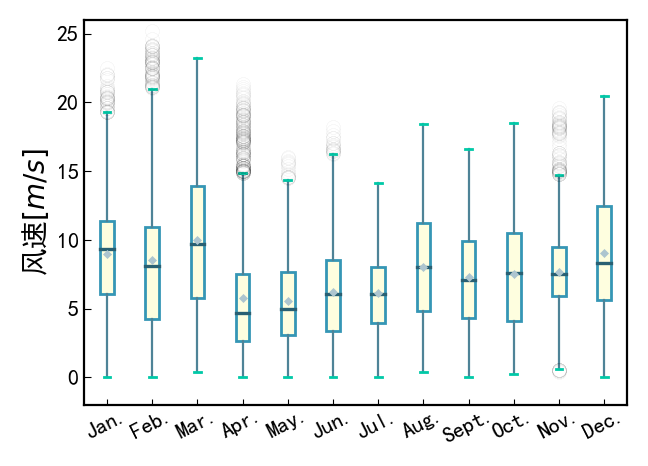

In [16]:
# 将配置重置为默认值
matplotlib.rcdefaults()
# 将配置重置为默认值
# plt.rcdefaults()
# config = {
#     "font.family": 'serif',
#     "font.size": 15,
#     "mathtext.fontset": 'stix',
#     "font.serif": ['SimSun']
# }
# plt.rcParams.update(config)


# matplotlib.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['text.usetex'] = True
# matplotlib.rcParams['mathtext.default'] = 'regular'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# plt.rcParams['font.family'] = 'Times New Roman'  # Helvetica Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

colors = ["#3596B5", "#FEFEDF", "#296073", "#ADC5CF", "#4E8397", "#00C9A7"]  # 0箱体边框、1箱体填充、2中位数线、3均值点、4须、5极值线、

# plt.figure(figsize=(3.5, 2.5),dpi=600) # 创建画板
fig, ax1 = plt.subplots(figsize=(3.5, 2.5), dpi=200)
plt.boxplot(ser,
            widths=0.3,  # 箱体边框宽度
            labels=['Jan.','Feb.','Mar.','Apr.','May.','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.'],
            patch_artist=True, boxprops={'color':colors[0], 'facecolor':colors[1], 'linewidth':1},  # 箱体边框颜色；箱体填充色；箱体框线粗细 lightblue
            medianprops=dict(color=colors[2], linewidth=1.2),  # 中位数线颜色、粗细
            showmeans=True, meanprops={'color':colors[3], 'markeredgecolor':colors[3], 'markerfacecolor':colors[3], 'marker':'D','markersize':1.3},  # 均值点标记
            whiskerprops=dict(color=colors[4], linewidth=.8),  # 须的颜色、粗细
            showcaps=True, capprops={'color':colors[5], 'linewidth':1},  # 极值线颜色、粗细
            showfliers=True, flierprops={'color':'b', 'linewidth':100, 'markeredgewidth':0.01, 'markersize':5})  # 异常值点设置, sym = '*', 'markeredgewidth':标记点轮廓线粗细, 'markersize':标记点大小

#设置主刻度标签的位置
# ax1.yaxis.set_major_locator(MultipleLocator(5)) #将y轴主刻度标签设置为 的倍数
# 设置次刻度标签的位置
# ax1.yaxis.set_minor_locator(MultipleLocator(1)) #将此y轴次刻度标签设置为 的倍数

plt.ylim((-2, 26))
# plt.title('Examples of boxplot', fontsize=20)  # 标题，并设定字号大小
plt.tick_params(axis='x', labelsize=8, direction='in', pad=0, length=2, width=0.4, rotation=27)  # 刻度值大小
plt.tick_params(axis='y', labelsize=8, direction='in', pad=2, length=2.4, width=0.4)
ax1.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3, color="green")
# plt.gcf().autofmt_xdate()  # 自动旋转日期标记
plt.ylabel('风速$[m/s]$', fontsize=10, labelpad=2)  # 设置 y 轴标签文字、大小
plt.xlabel('', fontsize=12)  # 设置 x 轴标签文字、大小
# plt.xticks(rotation=0)

plt.savefig("./temp/WS_monuth_CN.png", dpi=600)

plt.show

## 风速功率10min曲线

In [68]:
plot1.columns.values[0]

'wind speed(m/s)'

In [69]:
plot2.columns.values[0]

'theoretical power(kW)'

In [70]:
plot3.columns.values[0]

'active power(kW)'

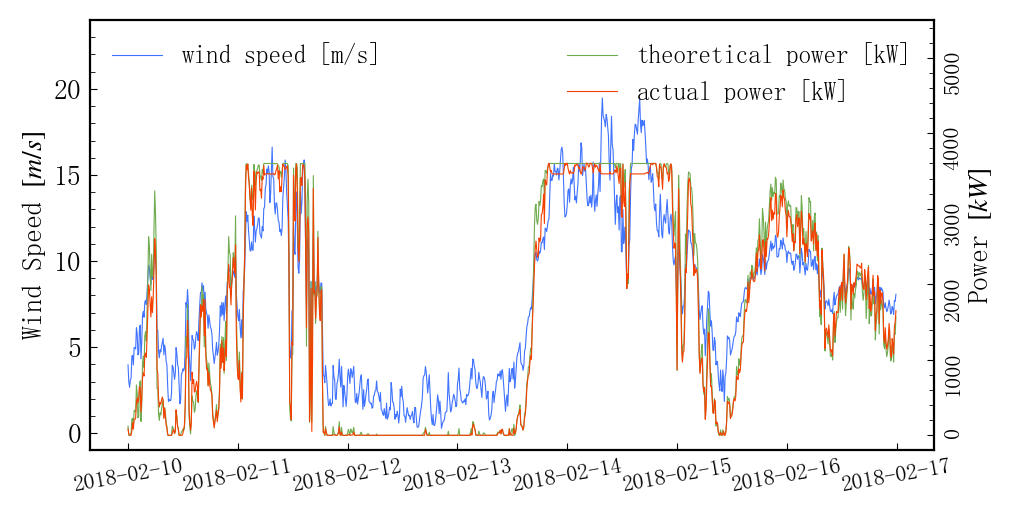

In [45]:
ser = serScada
s=144*40
e=s+1008
x=ser.index[s:e]  # x = ser.index

plot1=ser.iloc[s:e,[1]]
plot2=ser.iloc[s:e,[3]]
plot3=ser.iloc[s:e,[4]]
# 将配置重置为默认值
plt.rcdefaults()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)
# plt.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# plt.rcParams('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# plt.rcParams['font.sans-serif'] = ['mathcal']  # 设置中文编码'Microsoft YaHei''Times New Roman'
# plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
color = ['#4073FF', '#6FAB4F', '#F54100']
# 大小像素
fig, ax1 = plt.subplots(figsize=(5.5, 3), dpi=200)

# first part
ax1.plot(x, plot1, label='wind speed [m/s]', color=color[0], alpha=1, linewidth=0.4)  # 输入数据绘制第 1 个 y 轴折线图、设置折线颜色
plt.ylim((-1, 24))
# second part
ax2 = ax1.twinx()
ax2.plot(x, plot2, label='theoretical power [kW]', color=color[1], alpha=1, linewidth=0.4)  # 输入数据绘制第 2 个 y 轴折线图、设置折线颜色
ax2.plot(x, plot3, label='actual power [kW]', color=color[2], alpha=1, linewidth=0.4)
plt.ylim((-200, 5500))

#设置主刻度标签的位置
ax1.yaxis.set_major_locator(plt.MultipleLocator(5)) #将y轴主刻度标签设置为 的倍数
ax2.yaxis.set_major_locator(plt.MultipleLocator(1000))
#设置次刻度标签的位置
ax1.yaxis.set_minor_locator(plt.MultipleLocator(1)) #将此y轴次刻度标签设置为 的倍数
ax2.yaxis.set_minor_locator(plt.MultipleLocator(200))

# 横轴设置
plt.xticks(x)
ax1.tick_params(axis='x', direction='in', pad=2, labelsize=8, length=2.7, width=0.4, rotation=10)  # x 轴刻度值大小
# ax1.set_xlabel('sample point', fontsize=14)  # 设置 x 轴标签、字体大小
# 显示间隔数量
x_major_locator = plt.MultipleLocator(1)  # MultipleLocator()函数设置了x轴相邻显示点的间隔
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
# 纵轴设置
ax1.set_ylabel('Wind Speed $[m/s]$', fontsize=10, labelpad=2)  # 设置第 1 个 y 轴特征标签字体颜色、大小r'\textit{'+plot1.columns.values[0]+'}'
ax2.set_ylabel('Power $[kW]$', fontsize=10, labelpad=2)  # 设置第 2 个 y 轴特征标签字体颜色、大小
ax1.tick_params(axis='y', direction='in', pad=3, labelsize=10, length=2.4, width=0.4)  # 第 1 个 y 轴刻度值字体颜色大小, labelcolor=color
ax1.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3)
ax2.tick_params(axis='y', direction='in', pad=3, labelsize=8, length=2.4, width=0.4, rotation=90)  # 第 2 个 y 轴刻度值字体颜色、大小, labelcolor=color
ax2.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3)
# 图例 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'
ax1.legend(loc='upper left', frameon=False, fontsize=9)
ax2.legend(loc='upper right', frameon=False, fontsize=9)

# 画框
slw = 0.0001
ax1.spines['top'].set_linewidth(slw)
ax1.spines['bottom'].set_linewidth(slw)
ax1.spines['right'].set_linewidth(slw)
ax1.spines['left'].set_linewidth(slw)

# save and show
fig.tight_layout()
plt.savefig('output/windSpeedAndPower10min2.png', dpi=600)
plt.show()
plt.close(fig)

## 风速功率hour区间平均

In [62]:
s=144*40
e=s+1008
print(s/6)
print(e/6)

960.0
1128.0


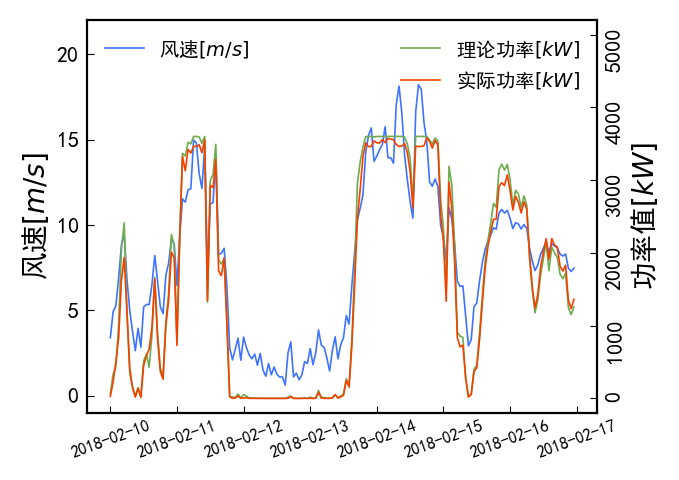

In [35]:
ser = serScada
ser = ser.resample('h', label='left', closed='left').mean()

s=960
e=1128
x=ser.index[s:e]  # x = ser.index
plot1=ser.iloc[s:e,[1]]
plot2=ser.iloc[s:e,[3]]
plot3=ser.iloc[s:e,[4]]

# 将配置重置为默认值
plt.rcdefaults()
# plt.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
color = ['#4073FF', '#6FAB4F', '#F54100']
# 大小像素
fig, ax1 = plt.subplots(figsize=(3.5, 2.5), dpi=200)

# first part
ax1.plot(x, plot1, label='风速$[m/s]$', color=color[0], alpha=1, linewidth=0.6)  # 输入数据绘制第 1 个 y 轴折线图、设置折线颜色
plt.ylim((-1, 22))
# second part
ax2 = ax1.twinx()
ax2.plot(x, plot2, label='理论功率$[kW]$', color=color[1], alpha=1, linewidth=0.6)  # 输入数据绘制第 2 个 y 轴折线图、设置折线颜色
ax2.plot(x, plot3, label='实际功率$[kW]$', color=color[2], alpha=1, linewidth=0.6)
plt.ylim((-200, 5200))

# 横轴设置
plt.xticks(x)
ax1.tick_params(axis='x', direction='in', pad=2, labelsize=6, length=2.7, width=0.4, rotation=20)  # x 轴刻度值大小
# ax1.set_xlabel('sample point', fontsize=14)  # 设置 x 轴标签、字体大小
# 显示间隔数量
# x_major_locator = plt.MultipleLocator(1)  # MultipleLocator()函数设置了x轴相邻显示点的间隔
# ax = plt.gca()
ax1.xaxis.set_major_locator(x_major_locator)

# 纵轴设置
ax1.set_ylabel('风速$[m/s]$', fontsize=10, labelpad=2)  # 设置第 1 个 y 轴特征标签字体颜色、大小r'\textit{'+plot1.columns.values[0]+'}'
ax2.set_ylabel('功率值$[kW]$', fontsize=10, labelpad=2)  # 设置第 2 个 y 轴特征标签字体颜色、大小
ax1.tick_params(axis='y', direction='in', pad=3, labelsize=8, length=2.4, width=0.4)  # 第 1 个 y 轴刻度值字体颜色大小, labelcolor=color
ax1.tick_params(axis='y', which='minor', direction='in', length=1.7, width=0.3)
ax2.tick_params(axis='y', direction='in', pad=3, labelsize=8, length=2.4, width=0.4, rotation=90)  # 第 2 个 y 轴刻度值字体颜色、大小, labelcolor=color
ax2.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3)
# 图例 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'
ax1.legend(loc='upper left', frameon=False, fontsize=7)
ax2.legend(loc='upper right', frameon=False, fontsize=7)

# 画框
slw = 0.0001
ax1.spines['top'].set_linewidth(slw)
ax1.spines['bottom'].set_linewidth(slw)
ax1.spines['right'].set_linewidth(slw)
ax1.spines['left'].set_linewidth(slw)

# save and show
fig.tight_layout()
plt.savefig('temp/windSpeedAndPowerHour.png', dpi=600)
plt.show()
plt.close(fig)

## 区间均值

In [73]:
for i in (np.array([1,2,3,4,6,8,12,24])):
    s=960
    e=1128
    s=int(s/i)
    e=int(e/i)
    ser = serScada
    ser = ser.resample(str(i)+'h', label='left', closed='left').mean()

    x=ser.index[s:e]  # x = ser.index
    plot1=ser.iloc[s:e,[1]]
    plot2=ser.iloc[s:e,[3]]
    plot3=ser.iloc[s:e,[4]]

    # 将配置重置为默认值
    plt.rcdefaults()
    plt.rcParams['text.usetex'] = True  # 全局开启
    plt.rcParams['font.family'] = 'Times New Roman'
    #     plt.rcParams('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    #     plt.rcParams['font.sans-serif'] = ['mathcal']  # 设置中文编码'Microsoft YaHei''Times New Roman'
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    color = ['#6ABAA3', '#47A0FF', '#DC5D8A']#FD702C#837EFF
    # 大小像素
    fig, ax1 = plt.subplots(figsize=(3.5, 2.5), dpi=600)

    # first part
    ax1.plot(x, plot1, label='Wind Speed[m/s]', color=color[0], alpha=1, linewidth=0.4)  # 输入数据绘制第 1 个 y 轴折线图、设置折线颜色
    plt.ylim((-1, 22))
    # second part
    ax2 = ax1.twinx()
    ax2.plot(x, plot2, label='Theoretical Power[kW]', color=color[1], alpha=1, linewidth=0.4)  # 输入数据绘制第 2 个 y 轴折线图、设置折线颜色
    ax2.plot(x, plot3, label='Active Power[kW]', color=color[2], alpha=1, linewidth=0.4)
    plt.ylim((-200, 5200))

    #设置主刻度标签的位置
    ax1.yaxis.set_major_locator(MultipleLocator(5)) #将y轴主刻度标签设置为 的倍数
    ax2.yaxis.set_major_locator(MultipleLocator(1000))
    #设置次刻度标签的位置
    ax1.yaxis.set_minor_locator(MultipleLocator(1)) #将此y轴次刻度标签设置为0.1的倍数
    ax2.yaxis.set_minor_locator(MultipleLocator(200))

    # 横轴设置
    plt.xticks(x)
    ax1.tick_params(axis='x', direction='in', pad=2, labelsize=6, length=2.7, width=0.4, rotation=20)  # x 轴刻度值大小
    # ax1.set_xlabel('sample point', fontsize=14)  # 设置 x 轴标签、字体大小
    # 显示间隔数量
    x_major_locator = plt.MultipleLocator(1)  # MultipleLocator()函数设置了x轴相邻显示点的间隔
    ax = plt.gca()
    ax.xaxis.set_major_locator(x_major_locator)
    # 纵轴设置
    ax1.set_ylabel('Wind Speed[m/s]', fontsize=12)  # 设置第 1 个 y 轴特征标签字体颜色、大小r'\textit{'+plot1.columns.values[0]+'}'
    ax2.set_ylabel('Magnitude of Power[kW]', fontsize=12)  # 设置第 2 个 y 轴特征标签字体颜色、大小
    ax1.tick_params(axis='y', direction='in', pad=3, labelsize=8, length=2.4, width=0.4)  # 第 1 个 y 轴刻度值字体颜色大小, labelcolor=color
    ax1.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3, color="green")
    ax2.tick_params(axis='y', direction='in', pad=3, labelsize=8, length=2.4, width=0.4)  # 第 2 个 y 轴刻度值字体颜色、大小, labelcolor=color
    ax2.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3, color="green")
    # 图例 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'
    ax1.legend(loc='upper left', frameon=False, fontsize=5)
    ax2.legend(loc='upper right', frameon=False, fontsize=5)

    # save and show
    fig.tight_layout()
    plt.savefig('temp/windTurbineInter/windSpeedAndPower'+str(i)+'Hour.png')
#     plt.show()
    plt.close(fig)

## 功率对应风速散布

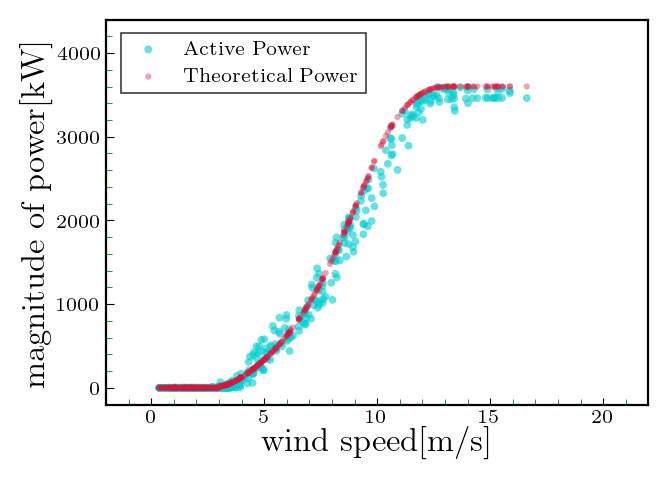

In [71]:
ser = serScada
s=144*40
e=s+1008-600
x=ser.iloc[s:e,[1]]  # 风速
plot1=ser.iloc[s:e,[3]]  # 理论功率
plot2=ser.iloc[s:e,[4]]  # 实际功率

# 将配置重置为默认值
plt.rcdefaults()
plt.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
# plt.rcParams['ytick.direction'] = 'in'

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(3.5, 2.5), dpi=200) #注意:一般都在ax中设置,不再plot中设置
area = [5,8]  # 点面积 
plt.xlabel("wind speed[m/s]", fontsize=12, labelpad=0)
plt.ylabel("magnitude of power[kW]", fontsize=12, labelpad=1.3)
plt.xlim(-2,22)
plt.ylim(-200,4400)

plt.scatter(x, plot2, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='Active Power')
plt.scatter(x, plot1, s=area[0], marker='o', c=colors[0], edgecolors='none', alpha=0.4, label='Theoretical Power')

#修改主刻度
xmajorLocator = MultipleLocator(5) #将x主刻度标签设置为 的倍数
xmajorFormatter = FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
ymajorLocator = MultipleLocator(1000) #将y轴主刻度标签设置为 的倍数
ymajorFormatter = FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
#设置主刻度标签的位置,标签文本的格式
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ymajorFormatter)
#修改次刻度
xminorLocator = MultipleLocator(1) #将x轴次刻度标签设置为5的倍数
yminorLocator = MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
#设置次刻度标签的位置,没有标签文本格式
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=7, direction='in', pad=1.8, length=2.7, width=0.4)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=7, direction='in', pad=1.8, length=2.7, width=0.4)
ax.tick_params(axis="x", which='minor', direction='in', length=2, width=0.3, color="green")
ax.tick_params(axis="y", which='minor', direction='in', length=2, width=0.3, color="green")

legend = plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.01, 0.99), ncol=1,fancybox=False,
                    facecolor='white',edgecolor='black', fontsize=7)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.savefig('output/scatter of Wind Speed and Power.png', dpi=600)
plt.show()
plt.close(fig)

CN版本

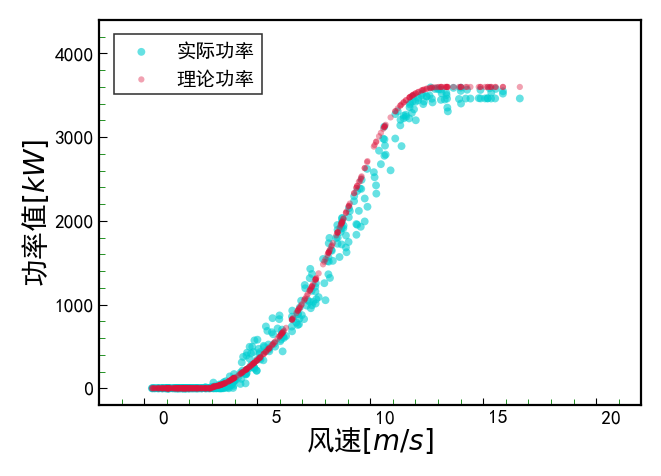

In [33]:
ser = serScada
s=144*40
e=s+1008-600
x=ser.iloc[s:e,[1]]  # 风速
plot1=ser.iloc[s:e,[3]]  # 理论功率
plot2=ser.iloc[s:e,[4]]  # 实际功率

# 将配置重置为默认值
plt.rcdefaults()
# plt.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
# plt.rcParams['ytick.direction'] = 'in'

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(3.5, 2.5), dpi=200) #注意:一般都在ax中设置,不再plot中设置
area = [5,8]  # 点面积 
plt.xlabel("风速$[m/s]$", fontsize=10, labelpad=0)
plt.ylabel("功率值$[kW]$", fontsize=10, labelpad=1.3)
plt.xlim(-2,22)
plt.ylim(-200,4400)

plt.scatter(x, plot2, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='实际功率')
plt.scatter(x, plot1, s=area[0], marker='o', c=colors[0], edgecolors='none', alpha=0.4, label='理论功率')

#修改主刻度
xmajorLocator = MultipleLocator(5) #将x主刻度标签设置为 的倍数
xmajorFormatter = FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
ymajorLocator = MultipleLocator(1000) #将y轴主刻度标签设置为 的倍数
ymajorFormatter = FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
#设置主刻度标签的位置,标签文本的格式
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ymajorFormatter)
#修改次刻度
xminorLocator = MultipleLocator(1) #将x轴次刻度标签设置为5的倍数
yminorLocator = MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
#设置次刻度标签的位置,没有标签文本格式
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=7, direction='in', pad=1.8, length=2.7, width=0.4)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=7, direction='in', pad=1.8, length=2.7, width=0.4)
ax.tick_params(axis="x", which='minor', direction='in', length=2, width=0.3, color="green")
ax.tick_params(axis="y", which='minor', direction='in', length=2, width=0.3, color="green")

legend = plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.01, 0.99), ncol=1,fancybox=False,
                    facecolor='white',edgecolor='black', fontsize=7)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.savefig('temp/scatter of Wind Speed and Power CN.png', dpi=600)
plt.show()
plt.close(fig)

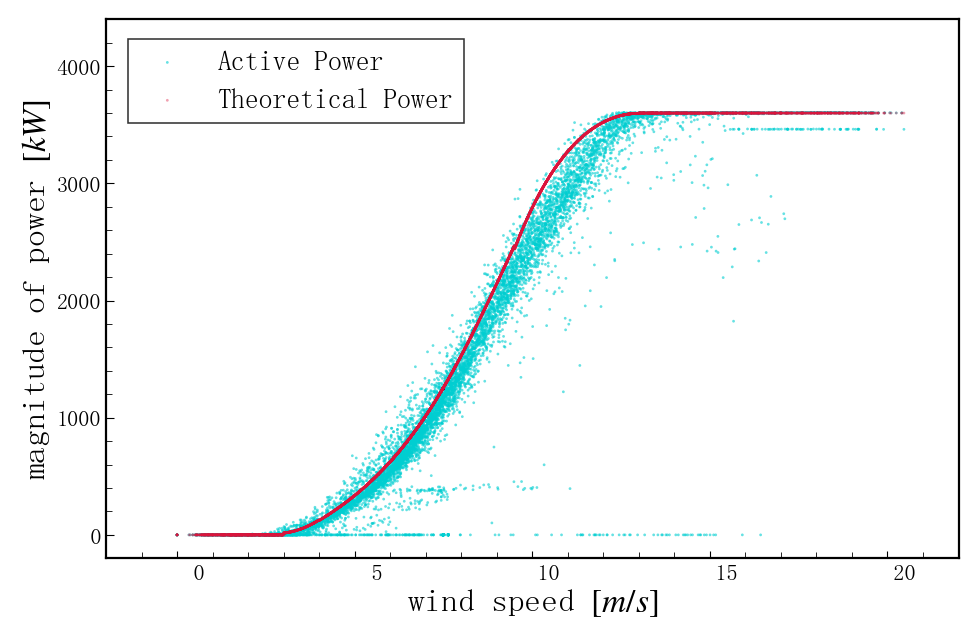

In [51]:
ser = serScada
s=40000
e=50000
x=ser.iloc[s:e,[1]]  # 风速
plot1=ser.iloc[s:e,[3]]  # 理论功率
plot2=ser.iloc[s:e,[4]]  # 实际功率


# 将配置重置为默认值
# plt.rcdefaults()
# plt.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
# plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(5.5, 3.5), dpi=200) #注意:一般都在ax中设置,不再plot中设置
area = [1,1]  # 点面积 
plt.xlabel("wind speed $[m/s]$", fontsize=12, labelpad=1)
plt.ylabel("magnitude of power $[kW]$", fontsize=12, labelpad=1.3)
plt.xlim(-2,22)
plt.ylim(-200,4400)

plt.scatter(x, plot2, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='Active Power')
plt.scatter(x, plot1, s=area[0], marker='o', c=colors[0], edgecolors='none', alpha=0.4, label='Theoretical Power')

#修改主刻度
xmajorLocator = MultipleLocator(5) #将x主刻度标签设置为 的倍数
xmajorFormatter = FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
ymajorLocator = MultipleLocator(1000) #将y轴主刻度标签设置为 的倍数
ymajorFormatter = FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
#设置主刻度标签的位置,标签文本的格式
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ymajorFormatter)
#修改次刻度
xminorLocator = MultipleLocator(1) #将x轴次刻度标签设置为5的倍数
yminorLocator = MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
#设置次刻度标签的位置,没有标签文本格式
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=8, direction='in', pad=1.8, length=2.7, width=0.4)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=8, direction='in', pad=1.8, length=2.7, width=0.4)
ax.tick_params(axis="x", which='minor', direction='in', length=2, width=0.3)#, color="green"
ax.tick_params(axis="y", which='minor', direction='in', length=2, width=0.3)#, color="green"

legend = plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.01, 0.99), ncol=1,fancybox=False,
                    facecolor='white',edgecolor='black', fontsize=10)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.savefig('output/scatter of Wind Speed and Power2.png', dpi=600)
plt.show()
plt.close(fig)

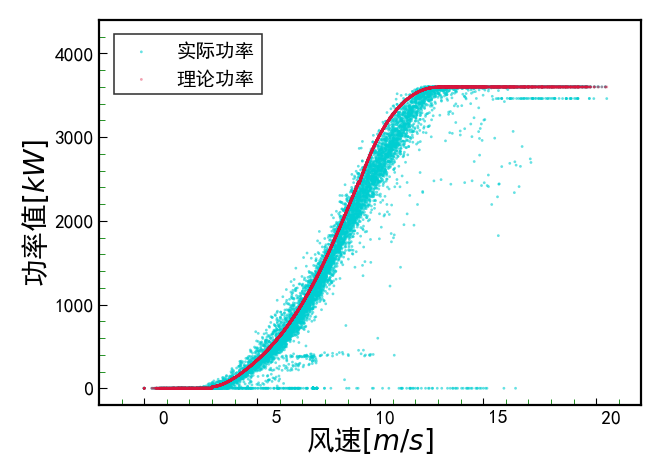

In [39]:
ser = serScada
s=40000
e=50000
x=ser.iloc[s:e,[1]]  # 风速
plot1=ser.iloc[s:e,[3]]  # 理论功率
plot2=ser.iloc[s:e,[4]]  # 实际功率


# 将配置重置为默认值
plt.rcdefaults()
# plt.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
# plt.rcParams['ytick.direction'] = 'in'

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(3.5, 2.5), dpi=200) #注意:一般都在ax中设置,不再plot中设置
area = [1,1]  # 点面积 
plt.xlabel("风速$[m/s]$", fontsize=10, labelpad=0)
plt.ylabel("功率值$[kW]$", fontsize=10, labelpad=1.3)
plt.xlim(-2,22)
plt.ylim(-200,4400)

plt.scatter(x, plot2, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='实际功率')
plt.scatter(x, plot1, s=area[0], marker='o', c=colors[0], edgecolors='none', alpha=0.4, label='理论功率')

#修改主刻度
xmajorLocator = MultipleLocator(5) #将x主刻度标签设置为 的倍数
xmajorFormatter = FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
ymajorLocator = MultipleLocator(1000) #将y轴主刻度标签设置为 的倍数
ymajorFormatter = FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
#设置主刻度标签的位置,标签文本的格式
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ymajorFormatter)
#修改次刻度
xminorLocator = MultipleLocator(1) #将x轴次刻度标签设置为5的倍数
yminorLocator = MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
#设置次刻度标签的位置,没有标签文本格式
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=7, direction='in', pad=1.8, length=2.7, width=0.4)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=7, direction='in', pad=1.8, length=2.7, width=0.4)
ax.tick_params(axis="x", which='minor', direction='in', length=2, width=0.3, color="green")
ax.tick_params(axis="y", which='minor', direction='in', length=2, width=0.3, color="green")

legend = plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.01, 0.99), ncol=1,fancybox=False,
                    facecolor='white',edgecolor='black', fontsize=7)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.savefig('temp/scatter of Wind Speed and Power2 CN.png', dpi=600)
plt.show()
plt.close(fig)

## hello

In [21]:
np.array(range(1,10))

array([1, 2, 3, 4, ..., 6, 7, 8, 9])

In [50]:
6*24*7

1008

# 模型评价指标对比

## data preparation

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# 调整增加输出窗口显示数据
np.set_printoptions(precision=6, threshold=8, edgeitems=4, linewidth=75, suppress=True, nanstr='nan', infstr='inf')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)


df = pd.DataFrame(
    data={
        'LSTM':[5262.6892727, 61211.25310330298, 247.40908047867399, 150.92020819094088, 56.34070287869963, 0.9660129552182316],
        'BiLSTM':[7639.2396284, 72940.68267869085, 270.07532778595464, 161.03393923472146, 57.31334410976152, 0.9595002859289666],
        'GRU':[4503.3638138999995, 66200.80137525403, 257.29516391734614, 150.82159836489265, 58.27025711238575, 0.9632425495826306],
        'RNN':[3064.0972036, 148230.00901573224, 385.0065051602794, 283.3095896439757, 70.56796158818072, 0.9176965067858123],
        'simpleRNN':[1402.6141867, 91431.48825473392, 302.3764016168159, 222.81275997267375, 62.0996854057524, 0.9492334182322157],
        'XgBoost':[15.5863617, 62482.72839088555, 249.96545439497345, 146.11380140008947, 56.876813948058846, 0.9653069790235431],
        'linearRegression':[531.2461562, 55159.994871442046, 234.86165049118182, 148.28905172382417, 57.06783655130501, 0.9693728665757921],
        'MIN':[0,0,0,0,0,0],
        'MAX':[8000,150000,400,300,80,1]},
    index = ['time','mse','rmse','mae','smape','r^2'])
df

,LSTM,BiLSTM,GRU,RNN,simpleRNN,XgBoost,linearRegression,MIN,MAX
time,5262.689273,7639.239628,4503.363814,3064.097204,1402.614187,15.586362,531.246156,0,8000
mse,61211.253103,72940.682679,66200.801375,148230.009016,91431.488255,62482.728391,55159.994871,0,150000
rmse,247.409080,270.075328,257.295164,385.006505,302.376402,249.965454,234.861650,0,400
mae,150.920208,161.033939,150.821598,283.309590,222.812760,146.113801,148.289052,0,300
smape,56.340703,57.313344,58.270257,70.567962,62.099685,56.876814,57.067837,0,80
r^2,0.966013,0.959500,0.963243,0.917697,0.949233,0.965307,0.969373,0,1


In [12]:
df.values


array([[  5262.689273,   7639.239628,   4503.363814,   3064.097204, ...,
            15.586362,    531.246156,      0.      ,   8000.      ],
       [ 61211.253103,  72940.682679,  66200.801375, 148230.009016, ...,
         62482.728391,  55159.994871,      0.      , 150000.      ],
       [   247.40908 ,    270.075328,    257.295164,    385.006505, ...,
           249.965454,    234.86165 ,      0.      ,    400.      ],
       [   150.920208,    161.033939,    150.821598,    283.30959 , ...,
           146.113801,    148.289052,      0.      ,    300.      ],
       [    56.340703,     57.313344,     58.270257,     70.567962, ...,
            56.876814,     57.067837,      0.      ,     80.      ],
       [     0.966013,      0.9595  ,      0.963243,      0.917697, ...,
             0.965307,      0.969373,      0.      ,      1.      ]])

In [13]:
consq = df.values.transpose()  # 转置 一行为一种模型不同参数
consq

array([[  5262.689273,  61211.253103,    247.40908 ,    150.920208,
            56.340703,      0.966013],
       [  7639.239628,  72940.682679,    270.075328,    161.033939,
            57.313344,      0.9595  ],
       [  4503.363814,  66200.801375,    257.295164,    150.821598,
            58.270257,      0.963243],
       [  3064.097204, 148230.009016,    385.006505,    283.30959 ,
            70.567962,      0.917697],
       ...,
       [    15.586362,  62482.728391,    249.965454,    146.113801,
            56.876814,      0.965307],
       [   531.246156,  55159.994871,    234.86165 ,    148.289052,
            57.067837,      0.969373],
       [     0.      ,      0.      ,      0.      ,      0.      ,
             0.      ,      0.      ],
       [  8000.      , 150000.      ,    400.      ,    300.      ,
            80.      ,      1.      ]])

## scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler


# scale train and test data to [0, 1]
def scale(data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(data)  # 使用 train 数据进行 fit ，进行统计计算，进行缩放；后续对 test 进行处理时使用同一标准
    # transform data
    data_scaled = scaler.transform(data)
    return data_scaled


consq_scaled = scale(consq)
consq_scaled

array([[0.657836, 0.408075, 0.618523, 0.503067, 0.704259, 0.966013],
       [0.954905, 0.486271, 0.675188, 0.53678 , 0.716417, 0.9595  ],
       [0.56292 , 0.441339, 0.643238, 0.502739, 0.728378, 0.963243],
       [0.383012, 0.9882  , 0.962516, 0.944365, 0.8821  , 0.917697],
       ...,
       [0.001948, 0.416552, 0.624914, 0.487046, 0.71096 , 0.965307],
       [0.066406, 0.367733, 0.587154, 0.494297, 0.713348, 0.969373],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [1.      , 1.      , 1.      , 1.      , 1.      , 1.      ]])

In [15]:
consq_scaled[0,:]

array([0.657836, 0.408075, 0.618523, 0.503067, 0.704259, 0.966013])

## radar map

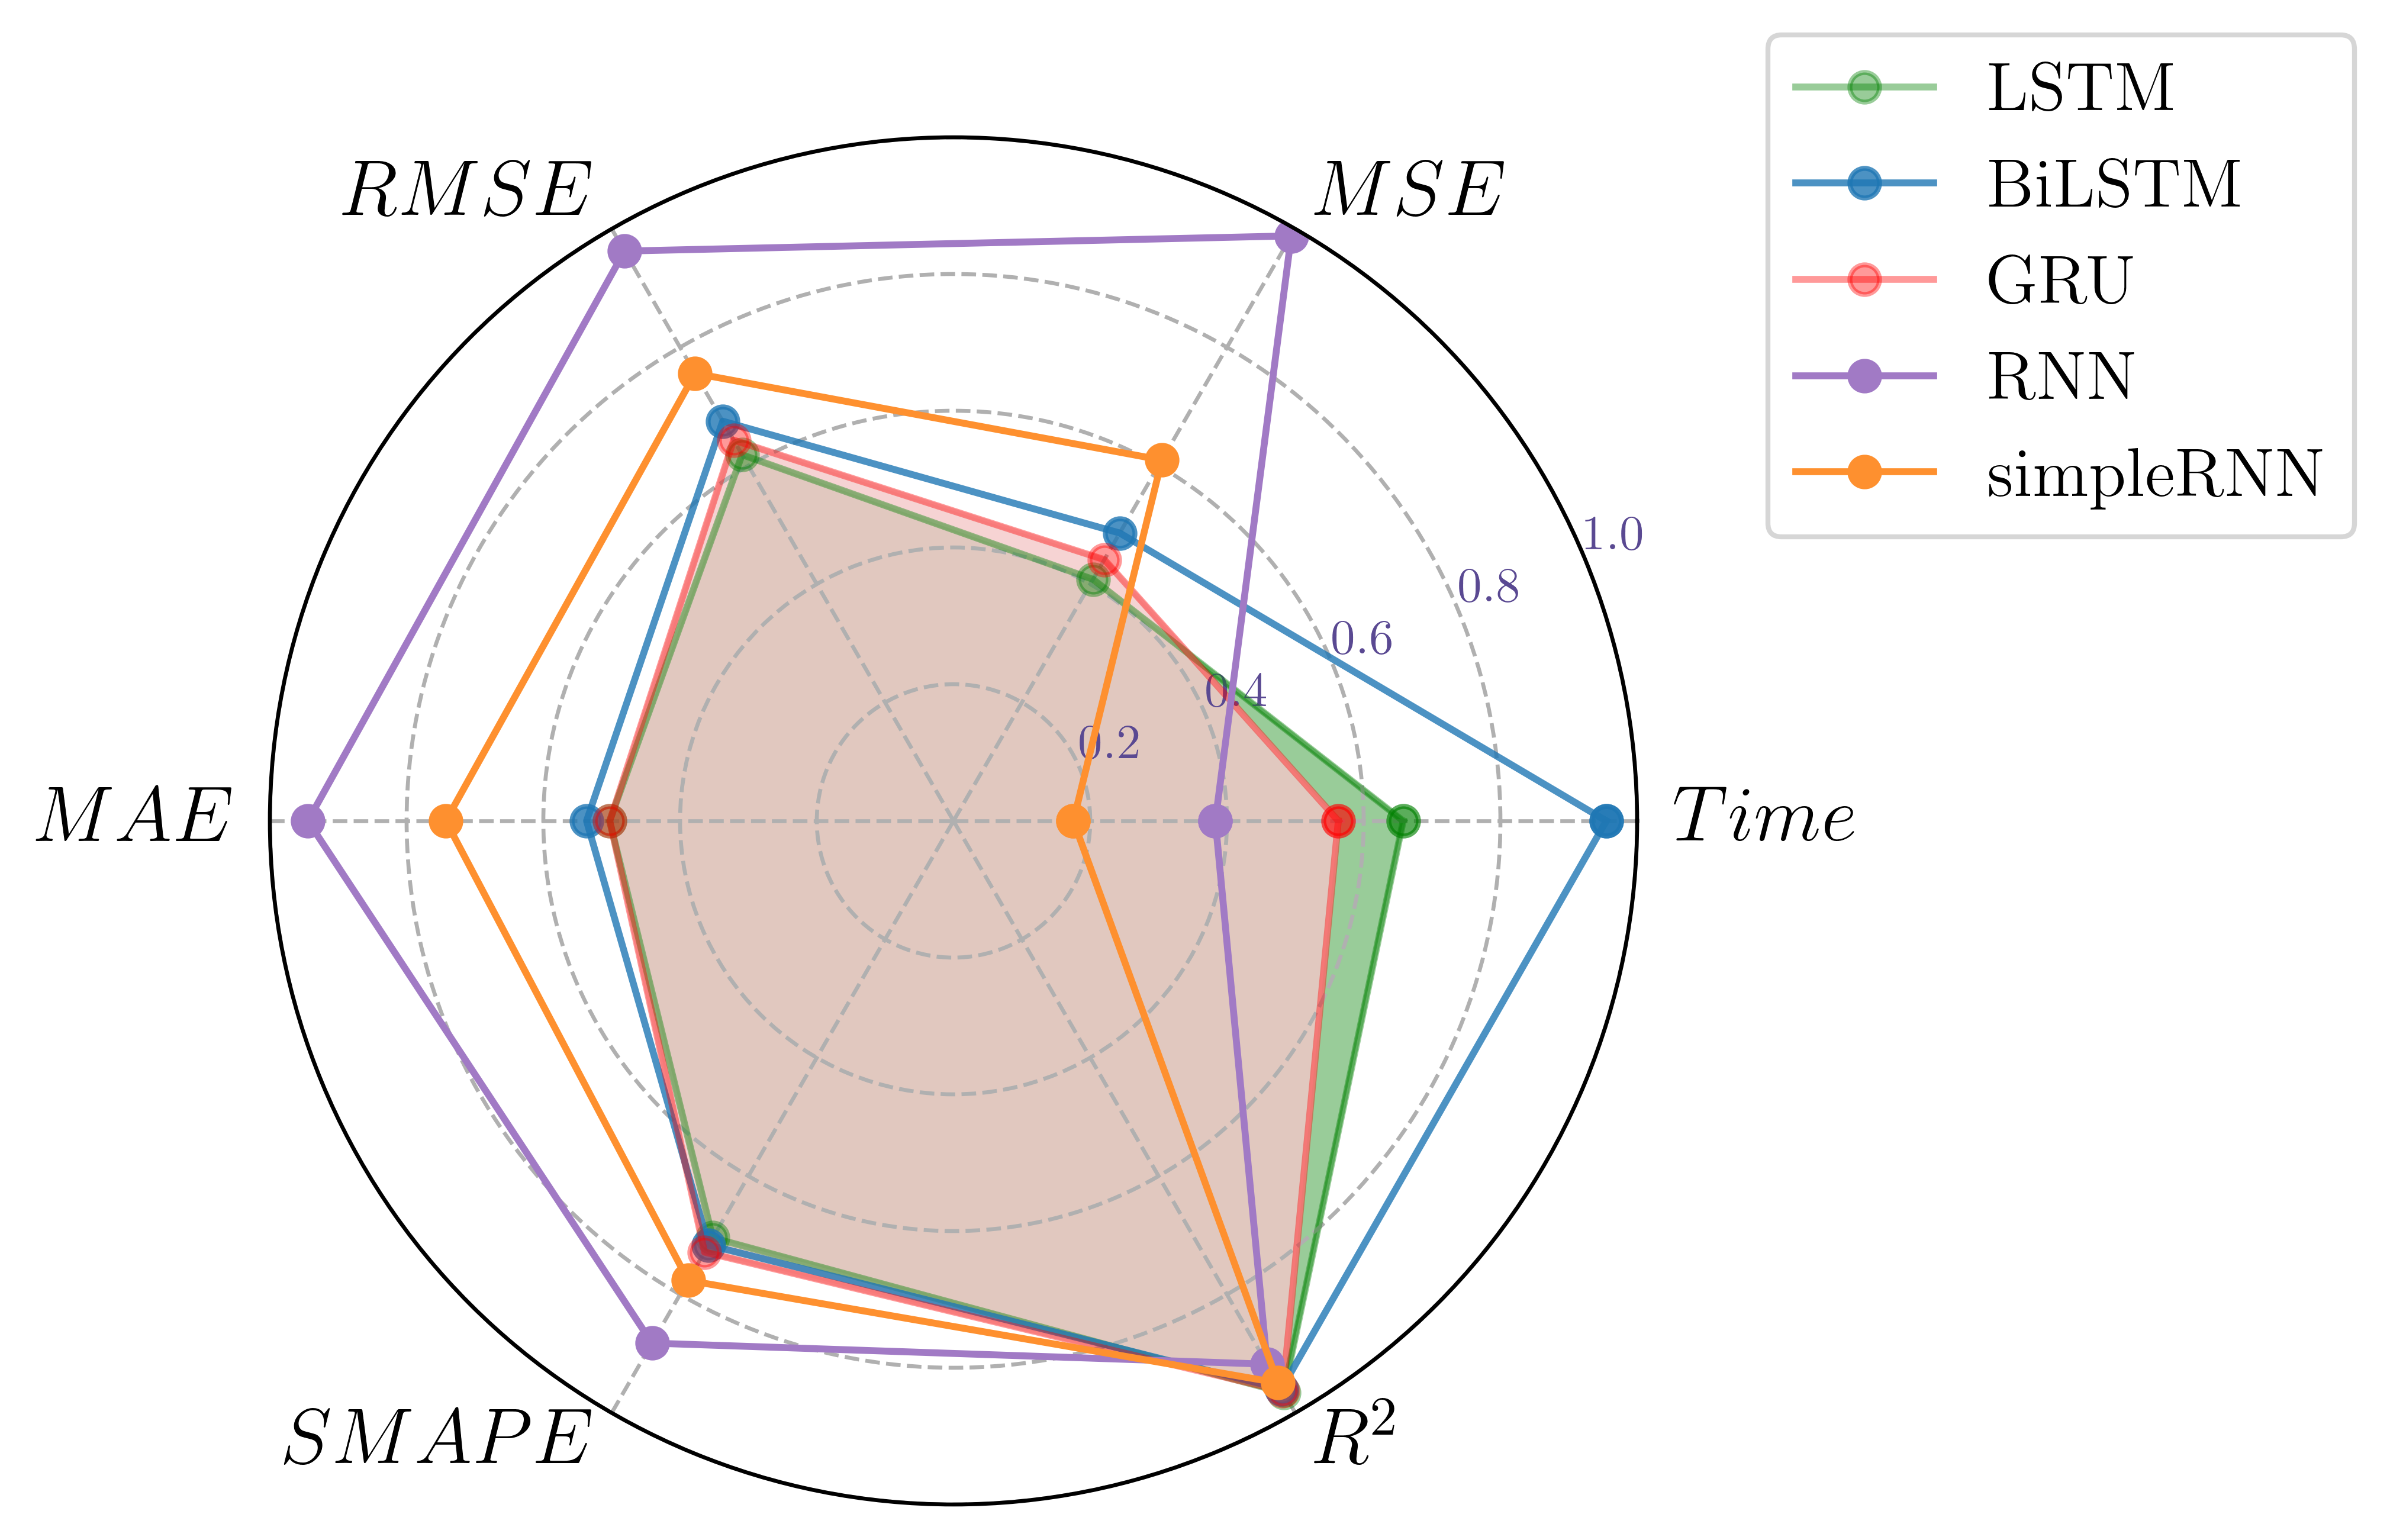

In [20]:
# 设置中文显示、画布大小
matplotlib.rcdefaults()  # 将配置重置为默认值
# matplotlib.use("Agg")
matplotlib.rcParams['text.usetex'] = True  # 全局开启
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.figure(figsize=(4.5*2, 2.5*2), dpi=600)
ax = plt.subplot(111, polar=True)

# 分割圆并执行闭合操作（0-2π之间返回间隔均匀的6个弧度：π/3、2π/3、π、4π/3、5π/3、2π）
theta = np.linspace(0, 2*np.pi, 6, endpoint=False)
theta = np.concatenate((theta, [theta[0]]))

# 设置两组数据并执行闭合操作
data1 = consq_scaled[0,:]
data2 = consq_scaled[1,:]
data3 = consq_scaled[2,:]
data4 = consq_scaled[3,:]
data5 = consq_scaled[4,:]
# data6 = consq_scaled[5,:]
# data7 = consq_scaled[6,:]
data1 = np.concatenate((data1, [data1[0]]))
data2 = np.concatenate((data2, [data2[0]]))
data3 = np.concatenate((data3, [data3[0]]))
data4 = np.concatenate((data4, [data4[0]]))
data5 = np.concatenate((data5, [data5[0]]))
# data6 = np.concatenate((data6, [data6[0]]))
# data7 = np.concatenate((data7, [data7[0]]))

# 绘制两组数据
plt.polar(theta, data1, 'o-', markersize=3*2, linewidth=0.7*2, color='g', alpha=0.4, label='LSTM')
plt.polar(theta, data2, 'o-', markersize=3*2, linewidth=0.7*2, color='#1f77b4', alpha=0.8, label='BiLSTM')
plt.polar(theta, data3, 'o-', markersize=3*2, linewidth=0.7*2, color='r', alpha=0.4, label='GRU')
plt.polar(theta, data4, 'o-', markersize=3*2, linewidth=0.7*2, color='#a17ac5', alpha=1, label='RNN')
plt.polar(theta, data5, 'o-', markersize=3*2, linewidth=0.7*2, color='#fe902f', alpha=1, label='simpleRNN')
# plt.polar(theta, data6, 'o-', label='XgBoost')
# plt.polar(theta, data7, 'o-', label='linearRegression')

# 调整圆周标签位置
for label,rot in zip(ax.get_xticklabels(),theta):
    if rot>=0 and rot<0.5*np.pi:
        label.set_horizontalalignment("left")
    if rot>0.5*np.pi and rot<1.5*np.pi:
        label.set_horizontalalignment("right")
    if rot>1.5*np.pi and rot<2*np.pi:
        label.set_horizontalalignment("left")

# 填充两组数据
plt.fill(theta, data1, color='g', alpha=0.4)
plt.fill(theta, data3, color='#f4c8c9', alpha=0.8)

# 将六个弧度（π/3、2π/3、π、4π/3、5π/3、2π）转换成角度，并分别设置标签
labels = np.array(['$Time$','$MSE$','$RMSE$','$MAE$','$SMAPE$','$R^2$'])
plt.thetagrids(theta[:6] * 180/np.pi, labels, fontsize=8*2)  # 圆周标签
plt.tick_params(labelsize=8*2, pad=-3, width=0.4*2)
plt.tick_params(axis='y', labelsize=7*2, pad=2*2) # , rotation=-70

# 设置刻度范围、标题、图例
plt.yticks(color="#5a4992", size=5*2)
plt.ylim(0, 1)  # 刻度范围
# plt.title('Title', fontsize=20)  # 标题
plt.legend(bbox_to_anchor=(1.55, 1.1), prop={"size":7*2})  # 右上角图例
plt.grid(linestyle='--',linewidth = 0.8)
plt.savefig('./temp/compare.png', dpi=600)
plt.show()


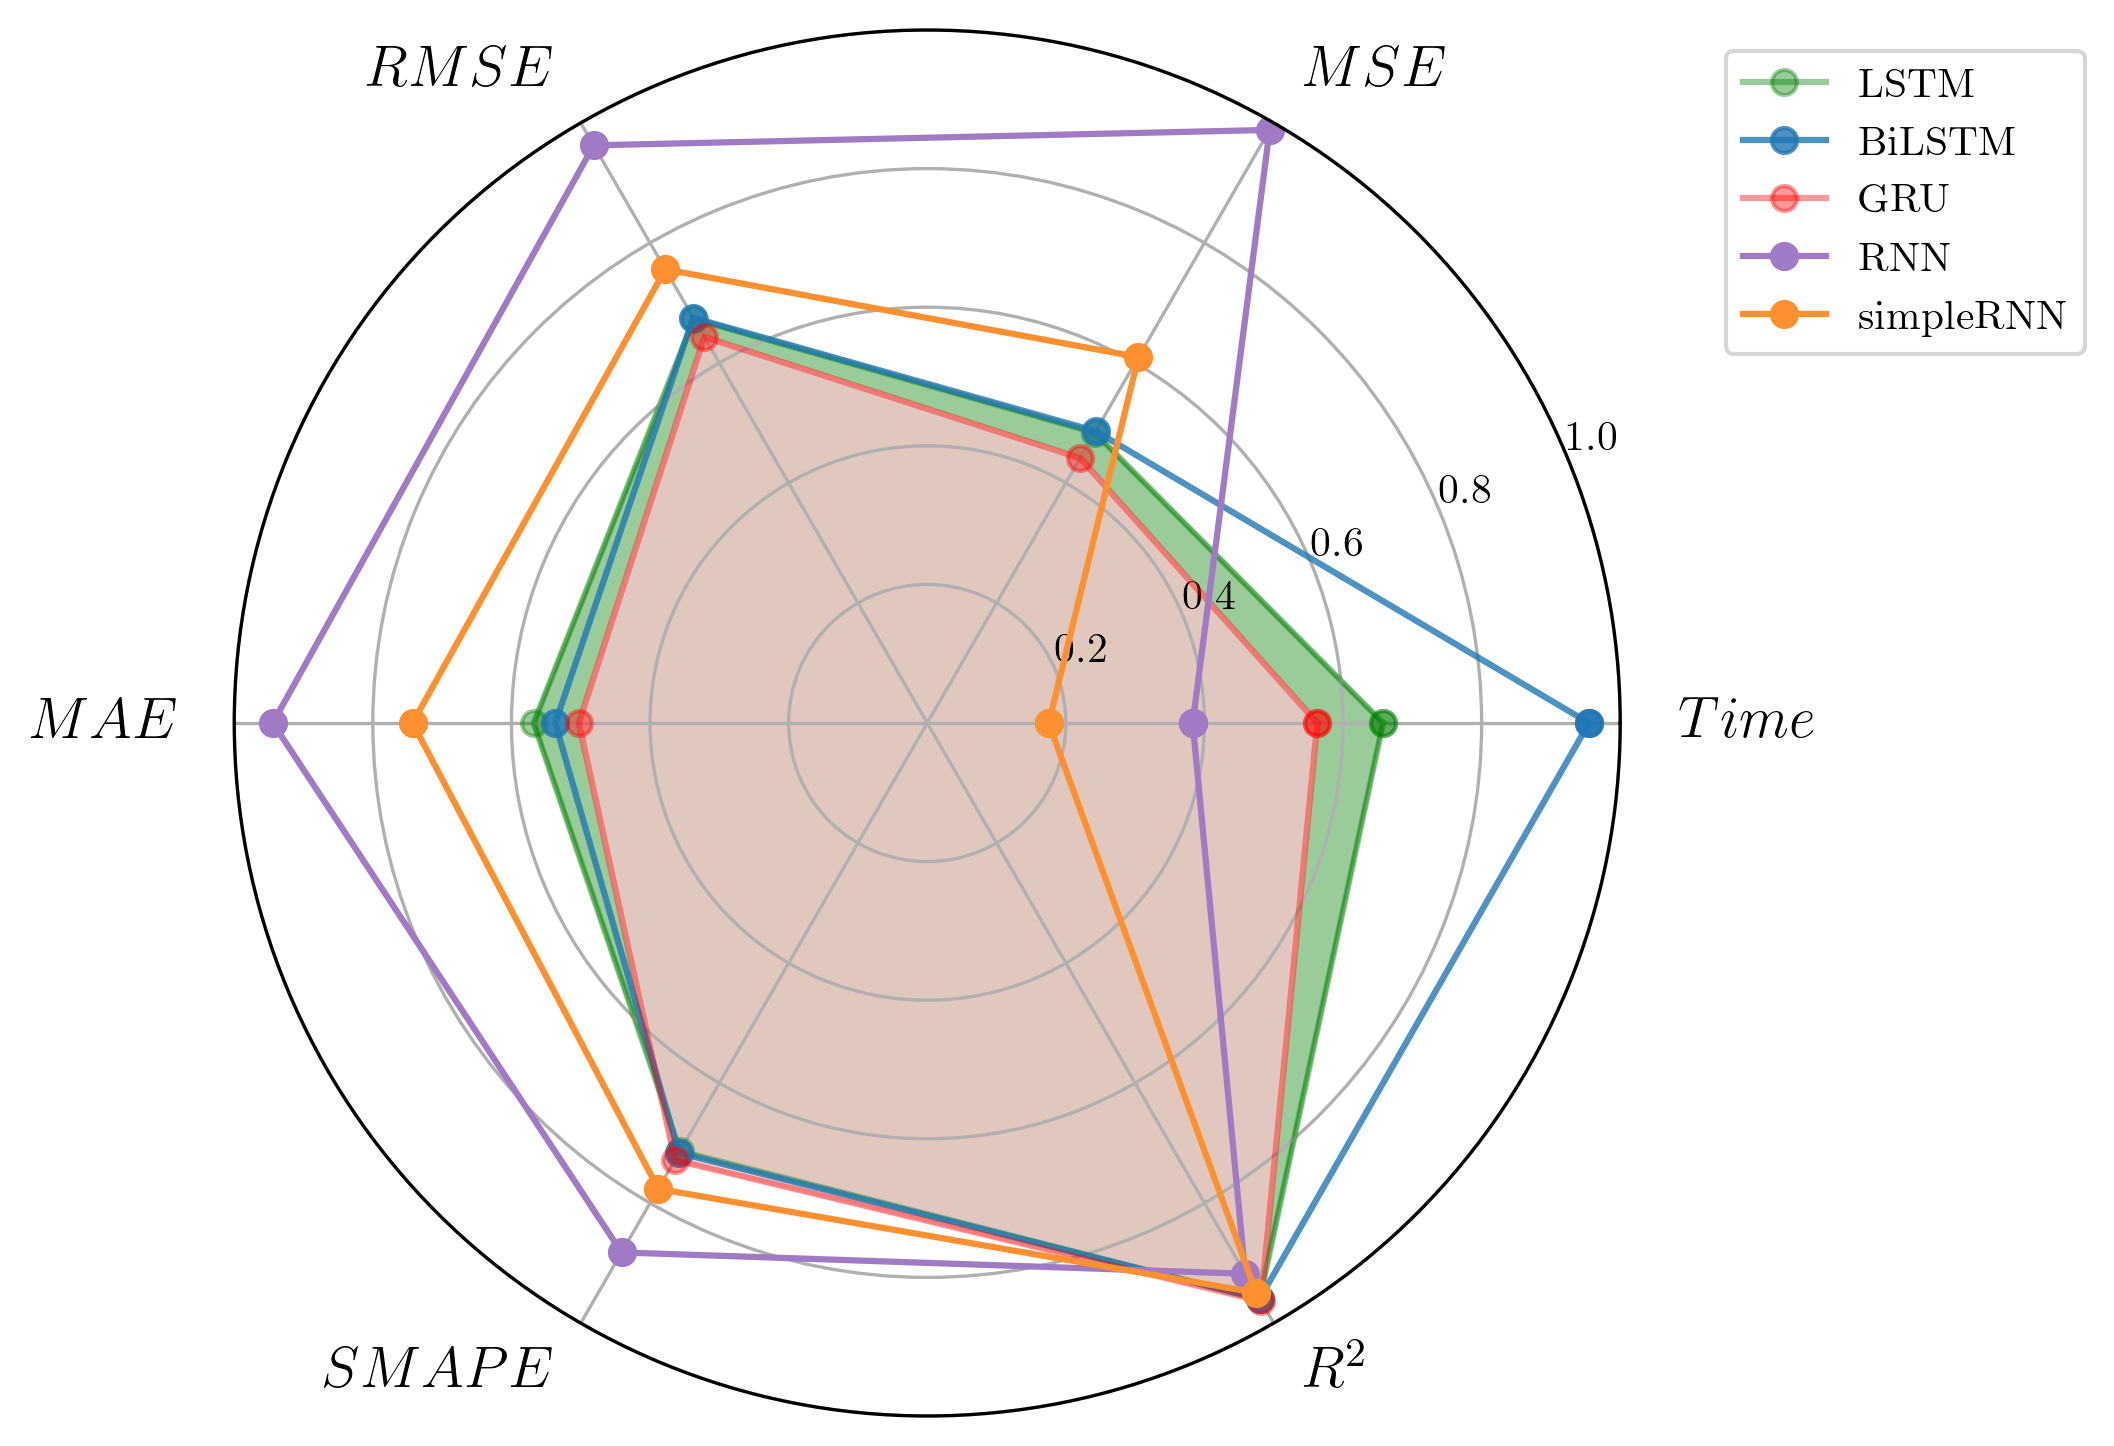

In [6]:
# 设置中文显示、画布大小
matplotlib.rcdefaults()  # 将配置重置为默认值
# matplotlib.use("Agg")
matplotlib.rcParams['text.usetex'] = True  # 全局开启
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.figure(figsize=(8.0, 6.0), dpi=300)
ax = plt.subplot(111, polar=True)

# 分割圆并执行闭合操作（0-2π之间返回间隔均匀的6个弧度：π/3、2π/3、π、4π/3、5π/3、2π）
theta = np.linspace(0, 2*np.pi, 6, endpoint=False)
theta = np.concatenate((theta, [theta[0]]))

# 设置两组数据并执行闭合操作
data1 = consq_scaled[0,:]
data2 = consq_scaled[1,:]
data3 = consq_scaled[2,:]
data4 = consq_scaled[3,:]
data5 = consq_scaled[4,:]
# data6 = consq_scaled[5,:]
# data7 = consq_scaled[6,:]
data1 = np.concatenate((data1, [data1[0]]))
data2 = np.concatenate((data2, [data2[0]]))
data3 = np.concatenate((data3, [data3[0]]))
data4 = np.concatenate((data4, [data4[0]]))
data5 = np.concatenate((data5, [data5[0]]))
# data6 = np.concatenate((data6, [data6[0]]))
# data7 = np.concatenate((data7, [data7[0]]))

# 绘制两组数据
plt.polar(theta, data1, 'o-', color='g', alpha=0.4, label='LSTM')
plt.polar(theta, data2, 'o-', color='#1f77b4', alpha=0.8, label='BiLSTM')
plt.polar(theta, data3, 'o-', color='r', alpha=0.4, label='GRU')
plt.polar(theta, data4, 'o-', color='#a17ac5', alpha=1, label='RNN')
plt.polar(theta, data5, 'o-', color='#fe902f', alpha=1, label='simpleRNN')
# plt.polar(theta, data6, 'o-', label='XgBoost')
# plt.polar(theta, data7, 'o-', label='linearRegression')

# 调整圆周标签位置
for label,rot in zip(ax.get_xticklabels(),theta):
    if rot>=0 and rot<0.5*np.pi:
        label.set_horizontalalignment("left")
    if rot>0.5*np.pi and rot<1.5*np.pi:
        label.set_horizontalalignment("right")
    if rot>1.5*np.pi and rot<2*np.pi:
        label.set_horizontalalignment("left")

# 填充两组数据
plt.fill(theta, data1, color='g', alpha=0.4)
plt.fill(theta, data3, color='#f4c8c9', alpha=0.8)

# 将六个弧度（π/3、2π/3、π、4π/3、5π/3、2π）转换成角度，并分别设置标签
labels = np.array(['$Time$','$MSE$','$RMSE$','$MAE$','$SMAPE$','$R^2$'])
plt.thetagrids(theta[:6] * 180/np.pi, labels, fontsize=14)  # 圆周标签

# 设置刻度范围、标题、图例
plt.ylim(0, 1)  # 刻度范围
# plt.title('Title', fontsize=20)  # 标题
plt.legend(bbox_to_anchor=(1.35, 1))  # 右上角图例
# plt.savefig('./temp/compare.png')  # './predict-wind-turbine/compare.png'
plt.show()
